
**By : Rendra Dwi Prasetyo**



### Load Data & Explore Data

In [ ]:
import pandas as pd

In [ ]:
DF = pd.read_csv('/content/data_1C.csv',index_col=0)

#index_col = 0, so that the first column in the CSV file does not become a separate column (but becomes the index of the dataframe)

In [ ]:
DF

Data in the form of text in English

In [ ]:
DF.info()

In [ ]:
# look the types of labels and their quantity
DF['label'].value_counts()

Label data shows that it is not an ordinal data type, so 1 label and other labels are independent (there is no order or level between labels).

In [ ]:
# check null/missing value
DF.isna().sum()

There are no null / missing values

### **a. Preprocessing**

Library untuk preprocessing

In [ ]:
import nltk
nltk.download('wordnet') # For English language
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [ ]:
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text) # remove URLs
    text = re.sub(r'\W', ' ', text)  # remove symbols / special character
    text = re.sub(r'\s+',' ',text) # remove double white space
    text = text.lower()  # change all character to lowercase (Case Folding)
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]
    return ' '.join(text)

DF['cleaned_text'] = DF['text'].apply(preprocess_text)

Explanation:

After exploring the dataset, I found out that the text data was in **English** so the library tool I used was in English.  

1. Tokenization:
Splitting text into individual words or tokens. For example "Text mining" becomes "text" and "mining"

2. Removal of Stopwords: Removing words that are common and do not provide much information. For example "and", "or", "then"

3. Deleting double white space: For example "rendra‎ ‎ dwi" becomes "rendra dwi", then I also delete symbols and links if they are in the text

3. Lemmatization is a concept like stemming which changes words into their basic form.
For example: "teaching" becomes "teach".

But here I don't use stemming, but rather **lemitization**, because it pays more attention to the morphological and grammatical context, where the results will be more precise than stemming.

In [ ]:
# Check the results of cleaning text
DF

In [ ]:
# Visualization with WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(DF['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear") # bilinear so that the image is smooth and not broken
plt.axis('off')
plt.show()

In [ ]:
# Additional Stopwords (Manual Removal)
# this list for words observed in the wordcloud that are not informative
additional_stopwords = ["u", "one," "x," "come," "provide," "offer," "give," "keep," "help," "support", "high," "quality," "perfect," "great," "better," "new," "unique," "beautiful","product," "life," "feature," "design," "set," "one," "time," "way," "type"]

#Combined stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(additional_stopwords)


def preprocess_text_with_additional_stopwords(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words] #using updated stopwords
    return ' '.join(text)


DF['cleaned_text'] = DF['text'].apply(preprocess_text_with_additional_stopwords) #apply new preprocessing

**Splitting dataset**

In [ ]:
from sklearn.model_selection import train_test_split

X = DF['cleaned_text'] # text that has been processed
y = DF['label']  # labels are targets, what I have identified earlier are 4 types of labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #traininng 80% and 20% data for testing

### **b. Modeling algorthm klasifikasi**

#### Vectorization method

There are 2 vectorization methods that I use:


* Method 1: TF-IDF
* Method 2: Bag of Word (BoW)



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Method 1: TF-IDF
tfidf_vectorizer = TfidfVectorizer() # object to carry out TF-IDF vectorization
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) # apply TF-IDF for training data
X_test_tfidf = tfidf_vectorizer.transform(X_test) # apply TF-IDF for testing data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer # Import CountVectorizer

# Method 2: Bag of Words (BoW)
bow_vectorizer = CountVectorizer() # object to carry out Bag of word Vectorization
X_train_bow = bow_vectorizer.fit_transform(X_train) #apply BoW for training data
X_test_bow = bow_vectorizer.transform(X_test) #apply BoW for testing data

TF-IDF = The product of the TF value (word frequency) and IDF (calculating how important a word is in the entire data set).

Bow = the result of calculating the frequency of word occurrences in a set of data.

In [ ]:
print(X_train_tfidf.shape)
print(X_train_bow.shape)

The results of TFIDF and Bag of Word vectorization dimensions for training data are quite large with 10084 text samples and 39628 features

#### **MODEL**

##### **I. Vectorization method 1 : TF-IDF**

###### **1. SVM**
Using vectorization method 1 : TF-IDF

* To find the best hyperparameters I use GridSearchCV because it can work by trying all parameter combinations to get the most optimal hyperparameters.
* **Hyperparameters** that I use are two, namely Kernel (linear and rbf) and C (between 0.1, 1 and 10)
* I divided the cross validaton (cv) into 5 fold sections to reduce overfitting, and the number of trials was as many as the number of hyperparameter combinations that can be obtained via Gridsearch.


I did this with consideration to get optimal results.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Tuning Hyperparameter for SVM
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear','rbf']}
svm_random = GridSearchCV(SVC(), svm_params, scoring='accuracy', cv=5)
svm_random.fit(X_train_tfidf, y_train)



In [ ]:
# get the accuracy value for each combination of parameters used
for mean_score, params in zip(svm_random.cv_results_['mean_test_score'], svm_random.cv_results_['params']):
    print(f"Score: {mean_score:.5f} with parameters: {params}")

print(f"\nBest Accuracy Score: {svm_random.best_score_:.5f} using parameters: {svm_random.best_params_}")

This C is a regulation that controls the trade-off between model complexity and training error. The results I got show that if the C value is too low the results are not as good as when the C value is larger, and in general the linear kernel is better than rbf.

****REPORT for test data****

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# SVM with TF-IDF
y_pred_svm_tfidf = svm_random.predict(X_test_tfidf)
print(classification_report(y_pred_svm_tfidf,y_test))


- The following are the values ​​for accuracy, precision, recall and f1 score without rounding:

In [ ]:
print("SVM (TF-IDF)  -> Accuracy  :", accuracy_score(y_test, y_pred_svm_tfidf))
print("SVM (TF-IDF)  -> Precision :", precision_score(y_test, y_pred_svm_tfidf, average='weighted'))
print("SVM (TF-IDF)  -> Recall    :", recall_score(y_test, y_pred_svm_tfidf, average='weighted'))
print("SVM (TF-IDF)  -> F1 Score  :", f1_score(y_test, y_pred_svm_tfidf, average='weighted'))

######**2. Random Forest**

Using vectorization method 1 : TF-IDF

* To find the best hyperparameters I use GridSearchCV because it works by trying all parameter combinations until I get the most optimal hyperparameter pair.
* **Hyperparameters** that I use are two, namely the number of estimates: n_estimators(50, 100, 200) and maximum depth (50, 100, None)  
* I divided the cross validaton (cv) into 5 fold parts.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [50, 100, None]}
rf_tfidf = GridSearchCV(RandomForestClassifier(), rf_params, scoring='accuracy', cv=5)
rf_tfidf.fit(X_train_tfidf, y_train)

In [ ]:
# accuracy value during training and selected parameters
for mean_score, params in zip(rf_tfidf.cv_results_['mean_test_score'], rf_tfidf.cv_results_['params']):
    print(f"Score: {mean_score:.3f} with parameters: {params}")
print(f"\nBest Accuracy Score: {rf_tfidf.best_score_:.3f} using parameter: {rf_tfidf.best_params_}")

From the results of the training scores, it can be seen that when the max_depth and n_estimator values ​​are higher, the scores during training are getting better.

**REPORT for test data**

In [ ]:
# Random Forest with TF-IDF
y_pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf) # to predict

# Display score accuracy, precision, recall and F1
print(classification_report(y_pred_rf_tfidf,y_test))

In [ ]:
# score without rounding
print("Random Forest (TF-IDF) - Accuracy:", accuracy_score(y_test, y_pred_rf_tfidf))
print("Random Forest (TF-IDF) - Precision:", precision_score(y_test, y_pred_rf_tfidf, average='weighted'))
print("Random Forest (TF-IDF) - Recall:", recall_score(y_test, y_pred_rf_tfidf, average='weighted'))
print("Random Forest (TF-IDF) - F1 Score:", f1_score(y_test, y_pred_rf_tfidf, average='weighted'))

#####  **II. Vectorization Method 2 : BoW (Bag of Word)**

######**1. SVM**

* To find the best hyperparameters, this time I used GridSearch which can see all the combination options for the parameters that I will determine.
* **Hyperparameters** that I use are two, namely Kernel (linear and rbf) and C (between 0.1, 1 and 10)
* I divided the cross validaton (cv) into 5 fold parts. Because using gridsearch, the number of combination attempts matches the total of all possible combinations

In [ ]:
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_bow = GridSearchCV(SVC(), svm_params, scoring='accuracy', cv=5)
svm_bow.fit(X_train_bow, y_train)

In [ ]:
# accuracy value during training and selected parameters
for mean_score, params in zip(svm_bow.cv_results_['mean_test_score'], svm_bow.cv_results_['params']):
    print(f"Score: {mean_score:.3f} with parameter: {params}")
print(f"\nBest Accuracy Score: {svm_bow.best_score_:.3f} using parameter: {svm_bow.best_params_}")

The most striking difference in the score results during training is in the kernel, in general the linear kernel gives better results.

**REPORT for test data**

In [ ]:
# SVM with Bag of Words
y_pred_svm_bow = svm_bow.predict(X_test_bow)

# Display score result of accuracy, precision, recall, f1-score
print(classification_report(y_pred_svm_bow,y_test))
print("SVM (BoW) -> Accuracy  :", accuracy_score(y_test, y_pred_svm_bow))

In [ ]:
print("SVM (BoW) -> Accuracy  :", accuracy_score(y_test, y_pred_svm_bow))
print("SVM (BoW) -> Precision :", precision_score(y_test, y_pred_svm_bow, average='weighted'))
print("SVM (BoW) -> Recall    :", recall_score(y_test, y_pred_svm_bow, average='weighted'))
print("SVM (BoW) -> F1 Score  :", f1_score(y_test, y_pred_svm_bow, average='weighted'))

######**2. Random Forest**

* To find the best hyperparameters I use GridSearch.
* **Hyperparameters** that I use are two, namely the number of estimates: n_estimators(50, 100, 200) and maximum depth (50, 100, None)  
* I divided the cross validaton (cv) into 5 fold sections, with 4x hyperparameter combination experiments.


I did this by considering getting optimal results but also with a computing time that was not too long

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Tuning Hyperparameter for Random Forest
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [50, 100, None]}
rf_bow = GridSearchCV(RandomForestClassifier(), rf_params, scoring='accuracy', cv=5)
rf_bow.fit(X_train_bow, y_train)


In [ ]:
# accuracy value during training and selected parameters
for mean_score, params in zip(rf_bow.cv_results_['mean_test_score'], rf_bow.cv_results_['params']):
    print(f"Score: {mean_score:.3f} with parameter: {params}")
print(f"\nBest Accuracy Score: {rf_bow.best_score_:.3f} using parameter: {rf_bow.best_params_}")


Training score data shows that in general using high max_depth and n_estimator hyperparameters will give better results

**REPORT for test data**

In [ ]:
# Random Forest with Bag of Words
y_pred_rf_bow = rf_bow.predict(X_test_bow)
print(classification_report(y_pred_rf_bow,y_test))
print("Random Forest (BoW) -> Accuracy  :", accuracy_score(y_test, y_pred_rf_bow))

In [ ]:
print("Random Forest (BoW) -> Accuracy  :", accuracy_score(y_test, y_pred_rf_bow))
print("Random Forest (BoW) -> Precision :", precision_score(y_test, y_pred_rf_bow, average='weighted'))
print("Random Forest (BoW) -> Recall    :", recall_score(y_test, y_pred_rf_bow, average='weighted'))
print("Random Forest (BoW) -> F1 Score  :", f1_score(y_test, y_pred_rf_bow, average='weighted'))

### **C. Performance Analysis**

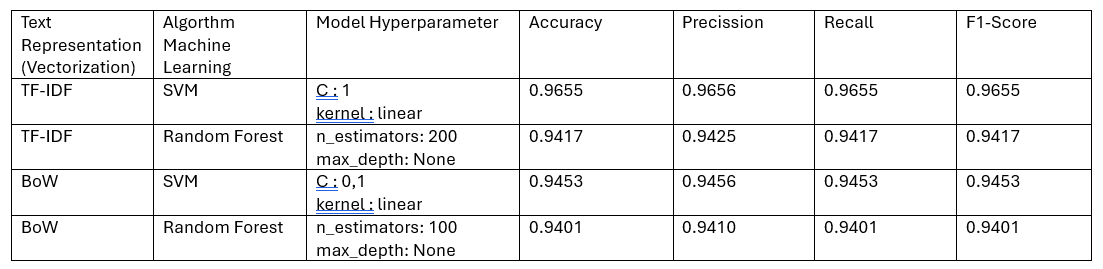

**Performance analysis**:


1. The SVM model with linear kernel shows excellent performance on both text representations. This indicates that SVM with a linear kernel is suitable for text classification problems with this C dataset.

2. The Random Forest model also gives good results. However, the performance results of Random Forest are slightly lower than SVM.


- **Hyperparameters**:

1. The C value in SVM affects the level of regularization. Higher C values ​​indicate a more complex model. However, from analysis via gridsearch, even though the C value is low, if combined with the right kernel it can provide quite optimal results.

2. n_estimators and max_depth in Random Forest, through the modeling that I did during training, the number of estimators and the maximum depth of the tree affects the complexity of the model. The more estimators and the deeper the tree, the more complex the model tends to be.

- **Conclusion**
1. SVM generally provides better results than Random Forest, for each of these algorithms, hyperparameter tuning also greatly influences the results obtained.

2. The best results were obtained using the TF-IDF technique for text representation/vectorization with the SVM (Support vector machine) algorithm with hyperparameter tuning (C=1 and kernel = linear)